# Heart Disease Classification
Phase 3 Project by Bella Scribner
- Flex
- Morgan Jones
- Date of Project Review: 1/8/24
- Blog: 

# Introduction

## Overview
This project creates a binary classification machine learning model to predict whether or not a patient has heart disease.  The project goes through a data exploration and cleaning process.  Pipelines are utlized for both preprocessing and data as well as for iterating through different types of models. After tuning the two models with highest performance a final model is chosen and evaluated.  Lastly, recommondations pulled from the model are given.

## The Business + Buisness Problem

Heart Disease is a leading cause of death not only in the United States, but globaly as well according to the World Health Organization and Center for Disease Control.  Cardiovascular diseases are estimated to be the cause of death for 17.9 million lives each year globally. 

This project is framed by a health care provider who would like to prevent further deaths by heart diseases with early identificaton and treatment.  A binary classification machine learning model is created that takes in patients' information and predicts whether or not heart disease is present. The upmost goal is to identify as many people as possible who are ill prior to any serious health crisises, such as a heart attack or stroke. Missing someone could be potentially fatal.  However, the health care providers are also concerned with falsely categorizing healthy people with heart disease as this can place an undue burden on a healthy patient.

## The Data Source

The data set used in this project, "Heart Failure Prediction Dataset," can be found on Kaggle.  The data is a combination of 5 seperate datasets from the UCI Machine Learning Repository under the index of heart diesease datasets. 

In [181]:
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, \
RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, \
accuracy_score, precision_score, f1_score, classification_report

# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImPipeline

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

# Data Exploration

First, let's take a look at what data we are working with.

In [2]:
data = pd.read_csv("heart.csv")
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Ideally, we wanted approximately 1,000 rows for this project; 918 data points is close enough, but we will have to be careful to keep as much data as possible.

Below is a more indepth description of all the variables we will be working with throughout the corse of this project.

| Column | Description | 
|:----|:----|
| **Age** | Age of the patient | 
| **Sex** | Sex of the patient |
| **ChestPainType** | Chest Pain Type: Typical Angina (TA), Atypical Angina (ATA), Non-Anginal Pain (NAP), or Asymptomatic (ASY) |
| **RestingBP** | Resting blood pressure (mm Hg) |
| **Cholesterol** | Serum Cholesterol (mm/dl) |
| **FastingBS** | Fasting blood sugar: 1 if FastingBS > 120 mg/dl, otherwise 0 |
| **RestingECG** | Resting electrocardiogram results: Normal (Normal), Having ST-T wave abnormality (ST), or Showing probable or definite left ventricular hypertrophy by Estes' criteria (LVH) | 
| **MaxHR** | Maximum heart rate achieved |
| **ExerciseAngina** | Yes if exercise-induced angina is present, otherwise No |
| **Oldpeak** | ST depression ('ST' relates to positions on the ECG plot) | 
| **ST_Slope** | The slope of the peak exercise ST segment: Upsloping (Up), Flat (Flat), or Downsloping (Down) | 
| **HeartDisease** | Target: 1 if the patient has heart disease, otherwise 0 |

In [5]:
# Missing Values Check
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
# Check basic statistics of numerical variables
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the above, we can see that most data points have a Fasting Blood Sugar below the cuttoff of 120 mg/dl.  More noteably, we can see that there are some values of 0 for both Cholesterol and Resting Blood Pressure.  We will assume that a zero value input is in place of a missing value (as having a resting blood pressure or cholesterol of zero is not possible). Let's look at the data points with these zero values.

In [52]:
data[data['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


Seeing as there is only one entry with a zero Resting Blood Pressure value, we will move forward with dropping this entry.  Next, we will examine the datapoints with zero values inputed for cholesterol.

In [11]:
data = data[data['RestingBP'] != 0]

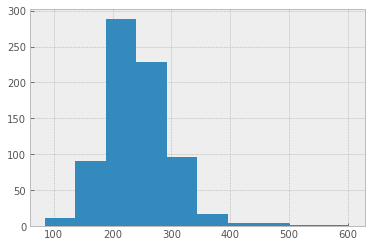

In [154]:
data['Cholesterol'].hist();

In [13]:
data[data['Cholesterol'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


In [14]:
data[data['Cholesterol'] == 0]['HeartDisease'].value_counts()

1    151
0     20
Name: HeartDisease, dtype: int64

That is a significant amount of entries!  And, a majority are entires where the patient does indeed have heart disease.  Seeing as we do not want to lose these data points, we will replace all zero values with a NaN, and later input the mean cholesterol for these entries.  

In [18]:
data.replace({'Cholesterol': {0 :np.nan}}, inplace=True)

In [19]:
data.isna().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           0
Cholesterol       171
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

Lastly, let's take a closer look at our target variable.

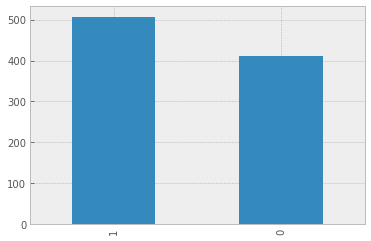

In [155]:
data['HeartDisease'].value_counts().plot.bar();

In [16]:
data['HeartDisease'].value_counts(normalize=True)

1    0.55289
0    0.44711
Name: HeartDisease, dtype: float64

We have a slight imbalance between the two target categories, but not one that requires any sort of data augmentation such as SMOTE.  Based on this distribution as well as the goals of the project, we will want to look at more than just accuracy when evaluating the models.  Recall will most definately be an important metric to evaluate our models.

Next, a peek at correlation with a heat map.  From there we will look at the distribution of the target variable in relation to a few of the independent variables.

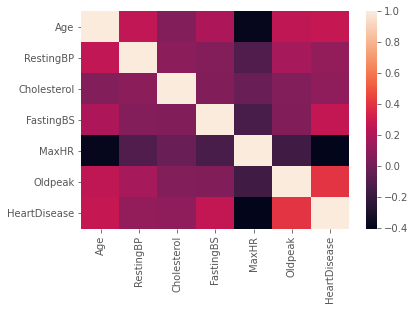

In [149]:
sns.heatmap(data.corr());

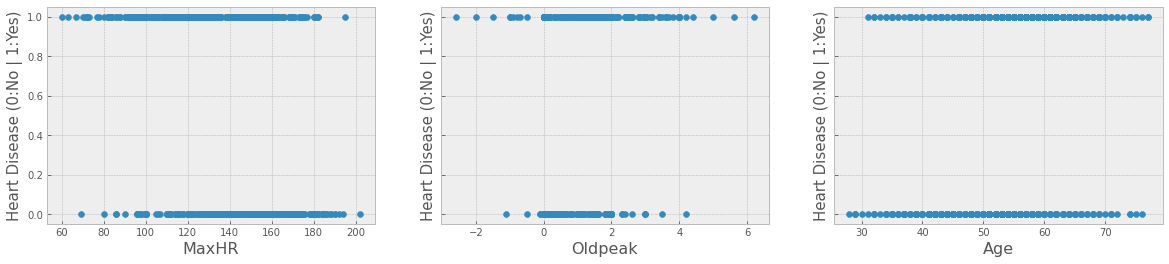

In [156]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(20,4))
i=0
for var in ['MaxHR', 'Oldpeak', 'Age']:
    a = i % 3
    ax[a].scatter(data['{}'.format(var)], data['HeartDisease'])
    ax[a].set_xlabel('{}'.format(var), fontsize=16)
    ax[a].set_ylabel('Heart Disease (0:No | 1:Yes)', fontsize=15)
    i+=1;

# Data Pre-Processing

Now that we have a better understanding of the data and its components, we can begin cleaning and prepping the data for modeling.

In [23]:
# Split data
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, random_state = 7)

In [24]:
# Create Validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, random_state = 7)

In [25]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
661,49,M,NAP,118,149.0,0,LVH,126,N,0.8,Up
645,57,M,NAP,128,229.0,0,LVH,150,N,0.4,Flat
190,46,M,ASY,180,280.0,0,ST,120,N,0.0,Up
415,66,F,ASY,155,NaN,1,Normal,90,N,0.0,Flat
188,50,F,ASY,120,328.0,0,Normal,110,Y,1.0,Flat


In [26]:
# Seperate Categorical variables in preperation of encoding
# We will include FastingBS as this is an over/under cutt off value 
cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Encoding of Categorical Data
X_encoded = ColumnTransformer(transformers = [("ohe", OneHotEncoder(handle_unknown="ignore", sparse = False),
                                                  cat_cols)], remainder = 'passthrough')

In [28]:
# Create the pipeline that will include all preprocessing steps:
    # 1. Encode the categorical data
    # 2. Inpute the mean for all missing values (cholesterol)
    # 3. Scale the data
preprocess_pipe = Pipeline(steps = [
    ('encode', X_encoded),
    ('num_impute', SimpleImputer()),
    ('ss', StandardScaler())
])

# Model Iteration 

Now that we have the preprocess pipeline staged for use, we will iterate through five different model types in order to compare and contrast how well each model performs with different evaluation metrics. Namely, wew will iterate through:

- Logistic Regression (we will use this as our baseline model)
- K-Nearest Neighbors
- Decision Tree Classifier
- Random Forest
- XGBoost

For these iterations we will be using the default settings for all hyperparameters for each model. 

In [31]:
def all_metrics(model, X_set, y_true):
    """
    Takes in a fitted model (or pipeline) as well as the X and y validation or test data,
    and returns the accuracy score, recall score, F1 score, precision score, and the confusion matrix.
    """
    # Predict
    y_preds = model.predict(X_set)
             
    # Accuracy
    accuracy = accuracy_score(y_true, y_preds)
       
    # Recall
    recall = recall_score(y_true, y_preds)
      
    # F1
    f1 = f1_score(y_true, y_preds)
        
    # Precision
    precision = precision_score(y_true, y_preds)
        
    # Confusion Matrix
    cnf_mtrx = confusion_matrix(y_true, y_preds)
    
    return accuracy, recall, f1, precision, cnf_mtrx

In [32]:
def model_comparison(models, X_set, y_true):
    """
    This function takes in a list of tuples in the form ('name of model', model) of the model(s) to iterate through.
    It also takes in the X and y validation or test data to be passed to the all_metrics helper function.
    The function returns the metrics found from all_metrics in dictionary format as well as a dictionary of
    the fitted models.
    """
    
    accuracy_scores = []
    recall_scores = []
    f1_scores = []
    precision_scores = []
    confusion_matrices = []
    fitted_models = {}
    
    for model_tuple in models:
        model_name = model_tuple[0]
        model = model_tuple[1]
        
        # Create Pipeline with preprocess + current model
        pipe = Pipeline(steps=[
            ('preprocess', preprocess_pipe),
            (model_name, model)
        ])
        
        # Fit
        pipe.fit(X_train, y_train)
        fitted_models['{}'.format(model_name)] = pipe
        
        # Find Metrics
        accuracy, recall, f1, precision, cnf_mtrx = all_metrics(pipe, X_set, y_true)
        accuracy_scores.append(accuracy)
        recall_scores.append(recall)
        f1_scores.append(f1)
        precision_scores.append(precision)
        confusion_matrices.append(cnf_mtrx)
        
    return {'Accuracy': accuracy_scores, 'Recall': recall_scores, 'F1': f1_scores, 
           'Precision': precision_scores}, confusion_matrices, fitted_models

Now that we have some helper functions that can iterate through our models and determine the metrics for us, let's pass through the five models we wish to run.

In [33]:
models = [('logistic_regression', LogisticRegression()), 
          ('knn', KNeighborsClassifier()), 
          ('classification_tree', DecisionTreeClassifier(random_state=7)), 
          ('random_forest', RandomForestClassifier(random_state=7)), 
          ('xgboost', XGBClassifier(random_state=7)) ]

metrics, confusion_matrices, fitted_models = model_comparison(models, X_val, y_val)

###  Visualize Results

In [163]:
def graph_metrics(model_names, metrics_list):
    """
    This function takes in a list of model names and a dictionary of lists containing the metrics from each 
    model respectively.  It creates a bar chart that displays each metric for each model.
    """
    width = 0.15
    multiplier = 0
    x = np.arange(len(model_names))
    
    fig, ax = plt.subplots(figsize=(20,8))
    
    for score_name, score_data in metrics_list.items():
        offset = width * multiplier
        ax.bar(x + offset, score_data, width, label=score_name)
        for x_n, s in zip(x+offset, score_data):
            ax.text(x_n, s, round(s,2), ha='center', va='bottom', fontsize=12)
        multiplier +=1
        
    ax.set_ylabel('Score Value', fontsize=18)
#    ax.set_xlabel('Model', fontsize=18)
    ax.set_title('Model Metrics Comparison', fontsize=22)
    ax.set_xticks(x + width)
    ax.set_xticklabels(model_names, fontsize=18)
    ax.legend(bbox_to_anchor=(1.05,1), loc='upper center');

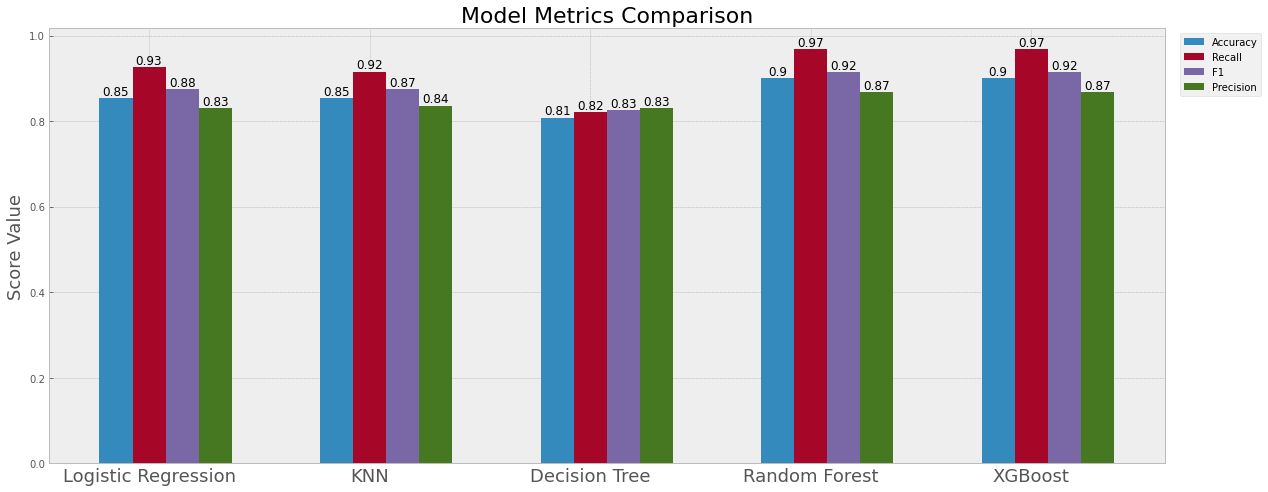

In [164]:
# Visualize each model's results
models_names = ('Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost')

graph_metrics(models_names, metrics)

It seems that our Random Forest and XGBoost models are performing the best overall.  Keeping in mind that the Logistic Regression is our 'baseline' to compare to, the K-Nearest Neighbor and Decision Tree models are both performing worse overall. This is not completely supprising as both of these models do tend to overfit without any hyperparameter tuning.

It appears that our Random Forest and XGBoost models have the exact results for all metrics! With recall at 97%, accuracy at 90%, and precision at 87%, our models are finding most of the datapoints in the target class, but are also mis-categorizing some datapoints that should be categorized as healthy as having heart disease.

In [169]:
# Confusion Matrix for each model
def plot_cnf_matrices(cnf_matrices, model_names):
    """
    This function takes in a list of confusion matrices as well as the name of each model the matrix was
    derived from and outputs a confusion matrix plot for each. Note that the function can take only up to six
    confusion matrices.
    """
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15,10), sharey=True, sharex=True)

    i = 0
    for cf in cnf_matrices:
        a = i // 3
        b = i % 3
    
        ax[a,b].set_title("{}".format(model_names[i]))
        disp = ConfusionMatrixDisplay(cf)
        disp.plot(ax=ax[a,b])
        i += 1
    
    fig.suptitle("Confusion Matrices", fontsize=18)
    plt.show()

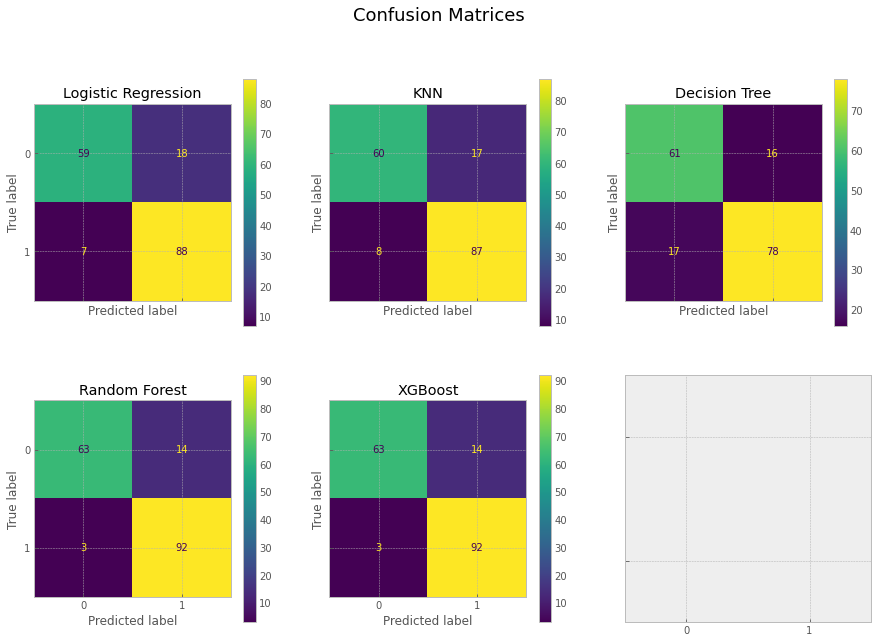

In [170]:
plot_cnf_matrices(confusion_matrices, models_names)

The above confusion matrices again show that the Random Forest and XGBoost models are out performing all other models.

## Hyperparameter Tuning

Now that we have evaluated our models using their default parameters, we will take the time to explore tuning the best model.  Seeing as the Random Forest Model and XGBoost models have identical metrics, we will go ahead and explore hyperparameter tuning with both of these models. 

We will go ahead and try a GridSearchCV as well as a RandomizedSearchCV with similar distributions. Furthermore, we will try these searches with a few different scoring values in the search.

In [38]:
def tuned_model_comparison(model_tuples, param_grids, scoring=None, random=False):
    """
    This model takes in a list of tuples formated ('model_name', model) for each model to iterate through.
    It also takes in a list of parameter girds (or distributions) for each model. The iterates through each model, 
    performs a grid search, or randomized search if 'random' is set to True, and returns the best estimator, 
    best parameters, and best score for each model.
    """
    best_results = {}
    
    for model_tuple, grid in zip(model_tuples, param_grids):
        
        # Build the estimator for the search
        model_name = model_tuple[0]
        model = model_tuple[1]
        estimator = Pipeline(steps=[
            ('preprocess', preprocess_pipe),
            (model_name, model)
        ])
        
        # Create Grid Search object
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
        if random == True:
            gs_pipe = RandomizedSearchCV(estimator=estimator, param_distributions=grid, scoring=scoring, cv=skf)
        else:
            gs_pipe = GridSearchCV(estimator=estimator, param_grid=grid, scoring=scoring, cv=skf)
        
        # Fit
        gs_pipe.fit(X_train, y_train)
        
        # Results
        best_results[model_name] = {'estimator': gs_pipe.best_estimator_, 
                                   'params': gs_pipe.best_params_,
                                   'score': gs_pipe.best_score_}
    return best_results

In [39]:
# Create grids for GridSearchCV

forest_param_grid = {'random_forest__max_depth': [2, 8, 15, None],
               'random_forest__max_features': [1, 3, 'sqrt'],
               'random_forest__n_estimators': [10, 50, 100],
               'random_forest__min_samples_split': [30, 10, 2]}

xgb_param_grid = {'xgboost__learning_rate': [0.01, 0.1, 0.8],
                  'xgboost__max_depth': [2, 5, 15],
                  'xgboost__n_estimators': [50, 100, 200],
                  'xgboost__gamma': [0.1, 2, 5, 10]}

param_grids = [forest_param_grid, xgb_param_grid]

In [40]:
# Create distributions for RandomizedSearchCV

rand_forest_param_grid = {'random_forest__max_depth': stats.randint(2, 15),
               'random_forest__max_features': stats.uniform(0,1),
               'random_forest__n_estimators': stats.randint(10, 100),
               'random_forest__min_samples_split': stats.uniform(0.01, 0.99)}

rand_xgb_param_grid = {'xgboost__learning_rate': stats.uniform(0.01, 0.08),
                  'xgboost__max_depth': stats.randint(2, 15),
                  'xgboost__n_estimators': stats.randint(50,200),
                  'xgboost__gamma': stats.uniform(.1, 10)}

rand_param_grids = [rand_forest_param_grid, rand_xgb_param_grid]

In [41]:
# Models to tune
tune_models = [('random_forest', RandomForestClassifier(random_state=7)), 
               ('xgboost', XGBClassifier(random_state=7)) ]

In [174]:
# Grid Search Results
best_models_std = tuned_model_comparison(tune_models, param_grids)
best_models_percision = tuned_model_comparison(tune_models, param_grids, scoring='precision')
best_models_recall = tuned_model_comparison(tune_models, param_grids, scoring='recall')

# Randomized Search Results
best_models_rand = tuned_model_comparison(tune_models, rand_param_grids, random=True)
best_models_rand_percision = tuned_model_comparison(tune_models, rand_param_grids, scoring='precision', random=True)
best_models_rand_recall = tuned_model_comparison(tune_models, rand_param_grids, scoring='recall', random=True)

### Visualize Results
Now that we have the results from all our searches stored, we will evaluate with our helper all_metrics, graph_metrics, and plot_cnf_matrices functions.

In [43]:
# Condense all results into one list
searched_models = [best_models_std, best_models_precision, best_models_recall, 
                  best_models_rand, best_models_rand_precision, best_models_rand_recall]

# Create lists of metrics to feed to graph_metrics function later
rf_accuracy_scores = []
rf_recall_scores = []
rf_f1_scores = []
rf_precision_scores = []
rf_confusion_matrices = []
    
xgb_accuracy_scores = []
xgb_recall_scores = []
xgb_f1_scores = []
xgb_precision_scores = []
xgb_confusion_matrices = []


# Iterate through results to find and store metrics for both Random Forest and XGB models

for model in searched_models:
   
    # Find and append metrics from the random forest model
    accuracy, recall, f1, precision, cnf_mtrx = all_metrics(model['random_forest']['estimator'], 
                                                           X_val, y_val)
    rf_accuracy_scores.append(accuracy)
    rf_recall_scores.append(recall)
    rf_f1_scores.append(f1)
    rf_precision_scores.append(precision)
    rf_confusion_matrices.append(cnf_mtrx)
    
    # Find and append metrics from the xgboost model
    accuracy, recall, f1, precision, cnf_mtrx = all_metrics(model['xgboost']['estimator'], 
                                                           X_val, y_val)
    xgb_accuracy_scores.append(accuracy)
    xgb_recall_scores.append(recall)
    xgb_f1_scores.append(f1)
    xgb_precision_scores.append(precision)
    xgb_confusion_matrices.append(cnf_mtrx)
    
# Create dictionary of metrics for each model type
rf_metrics = {'Accuracy': rf_accuracy_scores, 'Recall': rf_recall_scores, 'F1': rf_f1_scores, 
           'Precision': rf_precision_scores}
xgb_metrics = {'Accuracy': xgb_accuracy_scores, 'Recall': xgb_recall_scores, 'F1': xgb_f1_scores, 
           'Precision': xgb_precision_scores}

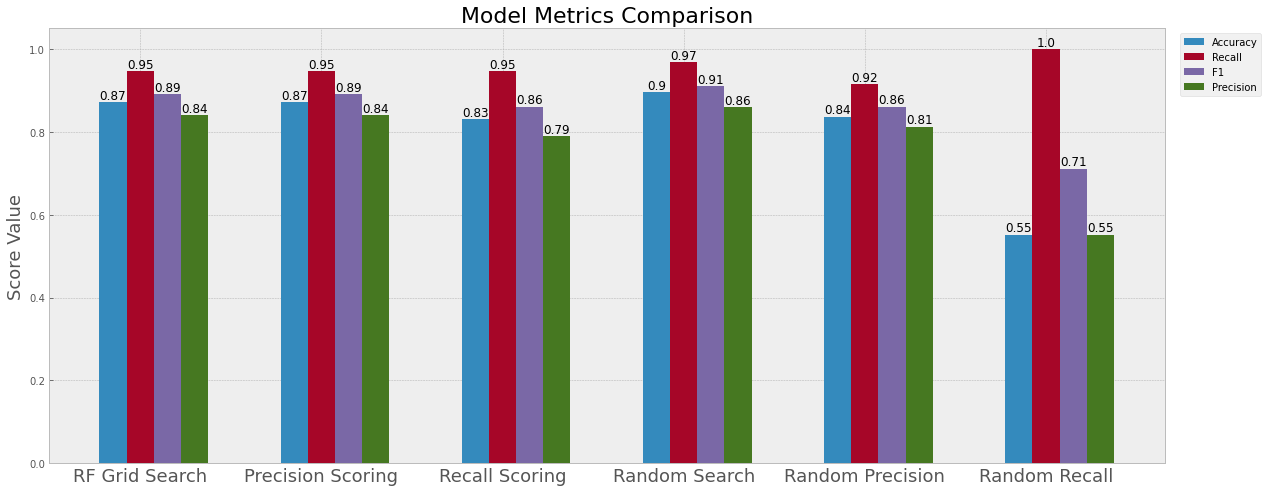

In [178]:
# Graph Random Forest Search Results
rf_names = ['RF Grid Search', 'Precision Scoring', 'Recall Scoring', 'Random Search', 
            'Random Precision', 'Random Recall']
graph_metrics(rf_names, rf_metrics)

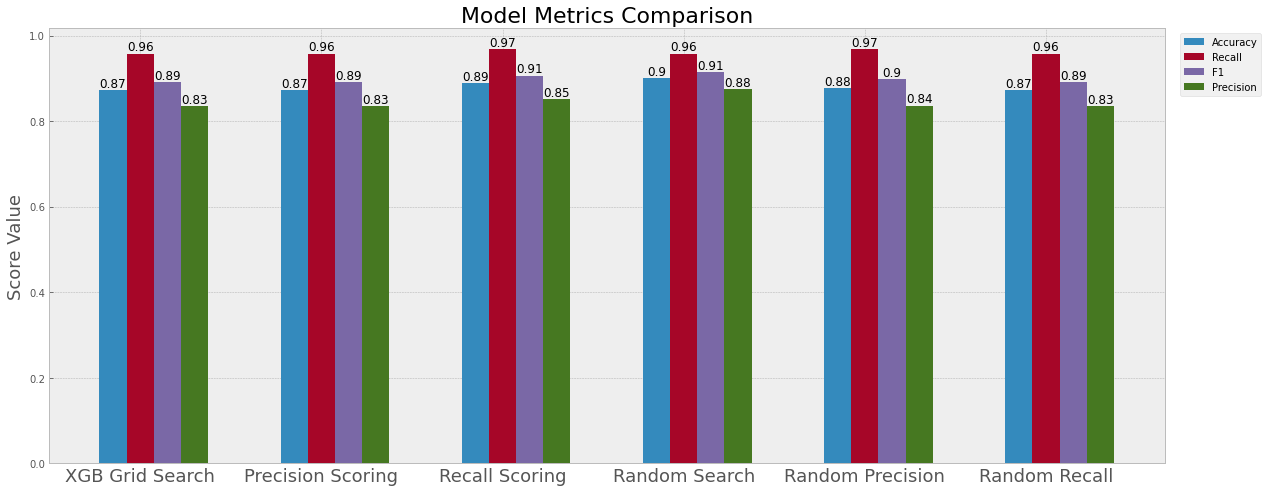

In [179]:
# Graph XGBoost Search Results
xgb_names = ['XGB Grid Search', 'Precision Scoring', 'Recall Scoring', 'Random Search', 
             'Random Precision', 'Random Recall']
graph_metrics(xgb_names, xgb_metrics)

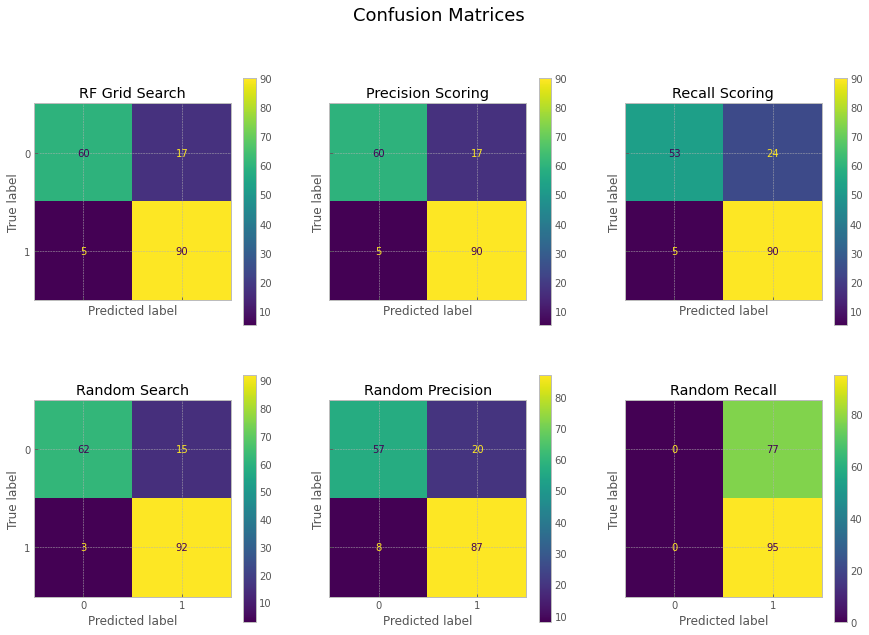

In [186]:
# Confusion Matrices for Random Forest Search Results
plot_cnf_matrices(rf_confusion_matrices, rf_names)

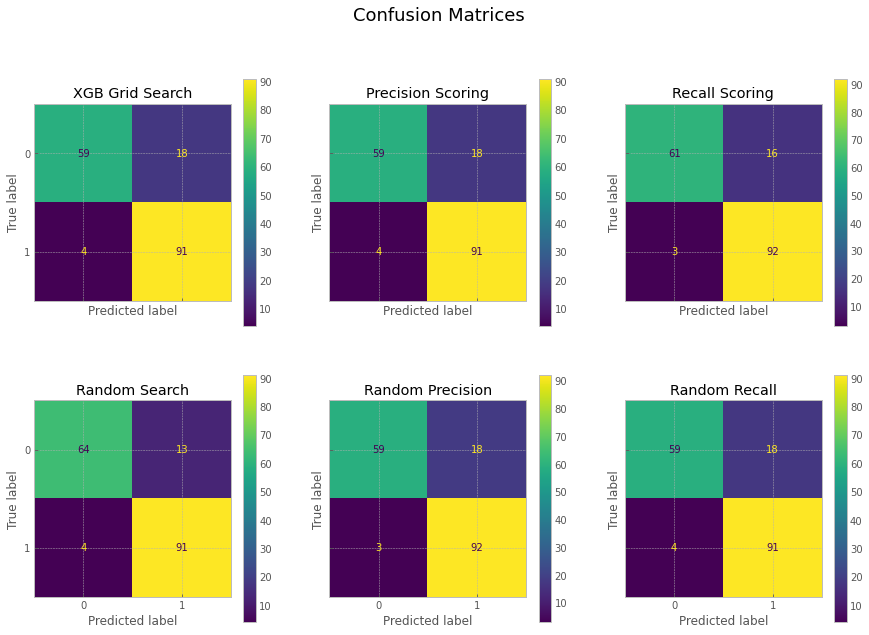

In [187]:
# Confusion Matrices for XGBoost Search Results
plot_cnf_matrices(xgb_confusion_matrices, xgb_names)

Seeing as all those visuals can be a bit overwhelming, lets pull out the data from the best models in order to compare and contrast only these.  The following out performed all other models:

- Random Forest model with default hyperparameters
- XGBoost model with default hyperparameters
    - Since the metrics were identical for these two, they will be represented as 'default_params' in the DataFrame below
- XGBoost using a GridSearchCV, with scoring set to Recall, to choose hyperparameters
- Random Forest with a RandomizedSearchCV to find hyperparameters (default scoring)
- XGBoost with a RandomizedSearchCV to find hyperparameters (default scoring)
- XGBoost with a RandomizedSearchCV, with scoring set to Precision, to find hyperparameters

In [191]:
pd.DataFrame({'default_params': [90,97,92,87], 'xgb_recall': [89, 97, 91, 85], 'rf_random': [90, 97, 91, 86],
              'xgb_random': [90, 96, 91, 88], 'xgb_random_precision':[88, 97, 90, 84]}, 
             index=['Accuracy', 'Recall', 'F1', 'Precision'])

,default_params,xgb_recall,rf_random,xgb_random,xgb_random_precision
Accuracy,90,89,90,90,88
Recall,97,97,97,96,97
F1,92,91,91,91,90
Precision,87,85,86,88,84


We are still seeing that the two best models are the Random Forest and XGBoost with the default parameters, however the Random Forest model that was found utilizing the RandomizedSearchCV (with default scoring) comes at a close second.  Let's take a look at the classification report for these three models in order to get a better idea of how they are performing in relation to each target class.

In [194]:
# Classification Report for the XGBoost model with default hyperparameters

preds = fitted_models['xgboost'].predict(X_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88        77
           1       0.87      0.96      0.91        95

    accuracy                           0.90       172
   macro avg       0.90      0.89      0.89       172
weighted avg       0.90      0.90      0.89       172



In [195]:
# Classification Report for the Random Forest model with default hyperparameters

preds = fitted_models['random_forest'].predict(X_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87        77
           1       0.86      0.97      0.91        95

    accuracy                           0.90       172
   macro avg       0.91      0.89      0.89       172
weighted avg       0.90      0.90      0.89       172



In [185]:
# Classification Report for the Random Forest Model with a RandomizedSearchCV to choose 
    # hyperparameters (default scoring)
    
preds = best_models_rand['random_forest']['estimator'].predict(X_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80        77
           1       0.81      0.93      0.86        95

    accuracy                           0.84       172
   macro avg       0.85      0.83      0.83       172
weighted avg       0.84      0.84      0.83       172



From all of the above, we can conclude that the best model available to us is the Random Forest model with default hyperparameters.

The Random Forest model found with the RandomizedSearchCV is simply not quite as accurate.  Out of the other two models, the recall score for the target variable is slightly higher with the Random Forest model.  We are most concerned with ensuring we find as many patients with heart disease as possible, thus we want recall to be as high as possible without sacrificing the accuracy score (again, we do not want to place an undue burdon on too many people by misclassifying them with heart disease when they are healthy).

# Final Model

Now that we have chosen our final model, we will train it with all of our training data (not just the 80% we have been using in order to utilize a validation set for the model iteration process), and evaluate it with the completely unseen test data.

In [242]:
final_model = Pipeline(steps=[
    ('preprocess', preprocess_pipe),
    ('random_forest', RandomForestClassifier(random_state=7))
])
final_model.fit(X_train_all, y_train_all)
final_accuracy, final_recall, final_f1, final_precision, final_cnf_mtrx = all_metrics(final_model, X_test, y_test)
final_metrics = [final_accuracy, final_recall, final_f1, final_precision]

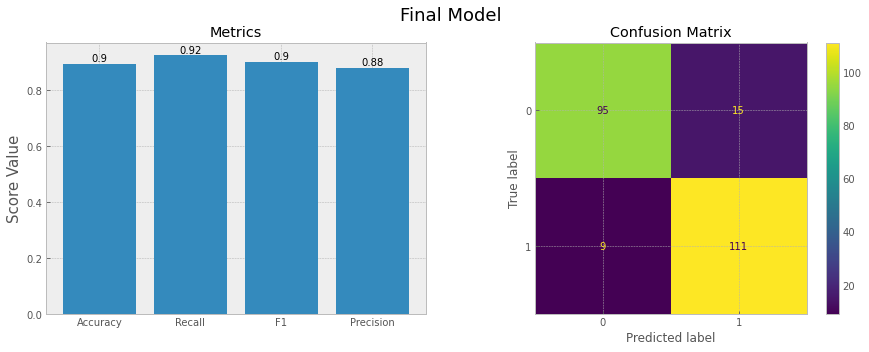

In [243]:
metric_names = ['Accuracy', 'Recall', 'F1', 'Precision']

fig, ax = plt.subplots(ncols=2, figsize=(15,5))

ax[0].bar(metric_names, final_metrics)
for name, score in zip(metric_names,final_metrics):
    ax[0].text(name, score, round(score,2), ha='center', va='bottom')
ax[0].set_title('Metrics')
ax[0].set_ylabel('Score Value', fontsize=15)

disp = ConfusionMatrixDisplay(final_cnf_mtrx)
disp.plot(ax=ax[1])
ax[1].set_title('Confusion Matrix')

fig.suptitle('Final Model', fontsize=18);

Let's also take a look at how important each feature was in our Random Forest.

- Write note here about how --> need to research this a bit more.

In [266]:
# Feature Names for Graph
feature_names = list(data.columns)[:-1]

# Run Permutation Importance
perm_results = permutation_importance(
    final_model, X_test, y_test, n_repeats=10,
    random_state=7, n_jobs=2)

# Format results for graph
forest_importances = pd.Series(perm_results.importances_mean, index=feature_names)

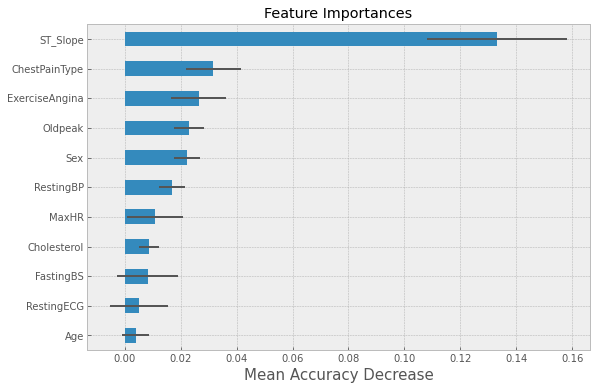

In [281]:
# Graph Feature Importances
fig, ax = plt.subplots(figsize=(9,6))

forest_importances.sort_values().plot.barh(
    xerr=perm_results.importances_std, ax=ax)

ax.set_title('Feature Importances')
ax.set_xlabel('Mean Accuracy Decrease', fontsize=15);

## Evaluation + Recommendations

- Evaluation
    - Note recall and accuracy scores
    - Comment on Feature Importances
- Recommendation
    - Can impletment model to assist in identifying patients with heart disease prior to a crisis.  
    - Moving forward, look closer into ST slope (and get more information concerning how patients feel during exercise)
        - Cite article about ST slope as a predictor of heart disease here